Using device: cuda
Loading dataset...
Dataset loaded successfully. Shape: (48856, 2)

Class Distribution:
classification
neutral              43313
depression            3831
anxiety               1005
suicidal_ideation      707
Name: count, dtype: int64

Preprocessing text...
Label Mapping: {'neutral': 0, 'depression': 1, 'suicidal_ideation': 2, 'anxiety': 3}

Initializing Tokenizer...


tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Initializing Model...


config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.225600,0.213662,0.919771,0.919405,0.919193,0.919771
2,0.094000,0.308693,0.928162,0.924137,0.922676,0.928162
3,0.001100,0.381030,0.928674,0.927131,0.925965,0.928674



Evaluating Model...


Validation Accuracy: 0.9198

---------------------------------------------------------
              CLASSIFICATION REPORT
---------------------------------------------------------
                   precision    recall  f1-score   support

          neutral       0.96      0.96      0.96      8663
       depression       0.63      0.65      0.64       766
suicidal_ideation       0.57      0.49      0.53       142
          anxiety       0.58      0.53      0.55       201

         accuracy                           0.92      9772
        macro avg       0.69      0.66      0.67      9772
     weighted avg       0.92      0.92      0.92      9772



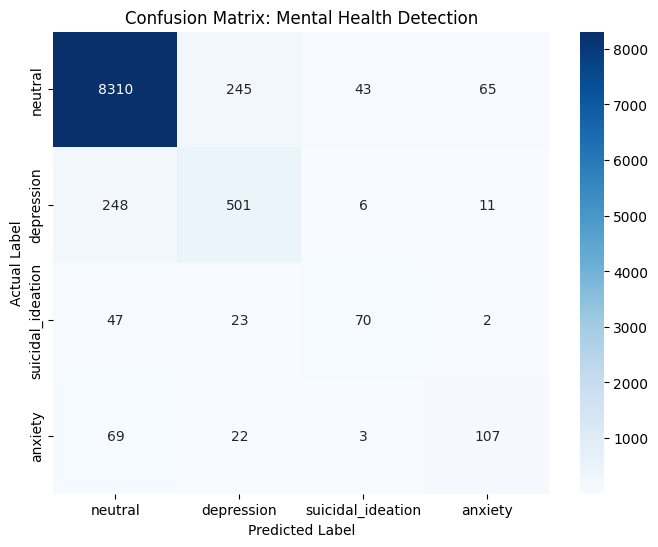


--- Testing on Sample Tweets ---
Tweet: انا اشعر بحزن شديد واكتئاب اليوم
Prediction: depression (Confidence: 0.97)

Tweet: الجو جميل جدا وانا سعيد
Prediction: neutral (Confidence: 0.99)

Tweet: تعبت من كل شي في الحياة
Prediction: depression (Confidence: 0.93)



In [1]:
# Mental Health Detection from Arabic Tweets
import torch
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# 1. CONFIGURATION & SETUP
# AraBERT model--> trained specifically on Arabic Twitter data
MODEL_NAME = "aubmindlab/bert-base-arabertv02-twitter"
MAX_LENGTH = 128  # max number of words the model will look at in each tweet
BATCH_SIZE = 16   # how many tweets to process at once
EPOCHS = 3        # how many times the model will see all the data
LEARNING_RATE = 2e-5  # how fast the model learns (small number = careful learning)
SEED = 42  # to get the same results every time we run it

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# To use GPU for faster processing.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. DATA PREPROCESSING
def clean_arabic_text(text):
    # removing unnecessary characters and normalizing different forms of letters
    # Check if the input is text
    if not isinstance(text, str):
        return ""

    # Remove diacritics (the small marks above/below Arabic letters)
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)

    # Normalize different forms of alef (أ إ آ) to just ا
    # This helps the model treat them as the same letter
    text = re.sub(r'[أإآ]', 'ا', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ـ', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove @mentions
    text = re.sub(r'@\w+', '', text)

    return text.strip()

print("Loading dataset...")
df = pd.read_csv('/content/arabic_tweets_classified.csv')
print(f"Dataset loaded successfully. Shape: {df.shape}")
print("\nClass Distribution:")
print(df['classification'].value_counts())

# pre-processing
print("\nPreprocessing text...")
df['clean_tweet'] = df['tweet'].apply(clean_arabic_text)

# Convert text labels to numbers, eg: "depression" becomes 0, "anxiety" becomes 1, etc.
label_map = {label: i for i, label in enumerate(df['classification'].unique())}
df['label'] = df['classification'].map(label_map)

# Keeping a reverse map so we can convert numbers back to labels later
reverse_label_map = {v: k for k, v in label_map.items()}
print(f"Label Mapping: {label_map}")

# Split data into training and validation sets (80% train, 20% validation)
# stratify makes sure each set has the same proportion of each class
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_tweet'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=SEED
)

# 3. DATASET CLASS
class MentalHealthDataset(Dataset):
    # Converts tweets into numbers that BERT can understand

    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        # Return how many tweets we have
        return len(self.texts)

    def __getitem__(self, item):
        # Get one tweet and prepare it for the model
        text = str(self.texts[item])
        label = self.labels[item]

        # Tokenize (convert words to numbers)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,   # adds CLS token at start and SEP token at end
            max_length=self.max_len,   # cut off if too long
            padding='max_length',       # add padding if too short (model processes multiple tweets at once, and they all need to be the same length)
            truncation=True,            # allow cutting long texts
            return_attention_mask=True, # tells model which parts are real vs padding (1 = real word, 0 = padding)
            return_tensors='pt'         # return as PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the tokenizer (this converts text to numbers)
print("\nInitializing Tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Create dataset objects
train_dataset = MentalHealthDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = MentalHealthDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)

# 4. MODEL INITIALIZATION
# Load the pre-trained AraBERT model
# We have added a classification layer on top for the specific task
print("\nInitializing Model...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_map)  # number of mental health categories we're predicting
)
model.to(device)  # move model to GPU if available

# 5. TRAINING CONFIGURATION
def compute_metrics(pred):
    # checking accuracy, precision, recall, and F1 score
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # get the predicted class

    # Calculate accuracy
    acc = accuracy_score(labels, preds)

    # precision, recall, and F1 from classification report
    # Using weighted average because some classes might have more samples
    precision, recall, f1, _ = classification_report(
        labels, preds, output_dict=True
    )['weighted avg'].values()

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Set up training parameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,             # how many times to go through all data
    per_device_train_batch_size=BATCH_SIZE,  # batch size for training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for validation
    warmup_steps=100,                    # gradually increase learning rate at start
    weight_decay=0.01,                   # helps prevent overfitting
    logging_dir='./logs',                # where to save logs
    logging_steps=10,                    # log every 10 steps
    eval_strategy="epoch",               # check validation performance each epoch
    save_strategy="epoch",               # save model each epoch
    load_best_model_at_end=True,         # load the best performing model at the end
    report_to="none"                     # don't send results to external services
)

# Create the trainer object that will handle training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 6. MODEL TRAINING
print("\nStarting Training...")
trainer.train()

# 7. MODEL EVALUATION
# model performance on validation data
print("\nEvaluating Model...")
eval_result = trainer.evaluate()
print(f"Validation Accuracy: {eval_result['eval_accuracy']:.4f}")

# predictions for all validation samples
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)

print("\n---------------------------------------------------------")
print("              CLASSIFICATION REPORT")
print("---------------------------------------------------------")
print(classification_report(val_labels, preds, target_names=label_map.keys()))

# Create confusion matrix to see which classes get confused with each other
cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix: Mental Health Detection')
plt.show()

# 8. PREDICTION FUNCTION
def predict_sentiment(text):
    # This function takes a new tweet and predicts its mental health category
    # Returns both the prediction and how confident the model is
    clean_text = clean_arabic_text(text)

    # Convert text to numbers
    inputs = tokenizer(clean_text, return_tensors="pt", truncation=True,
                      padding=True, max_length=MAX_LENGTH)

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction without calculating gradients (faster for inference)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the class with highest score
    prediction = torch.argmax(outputs.logits, dim=1).item()

    # Get confidence score (between 0 and 1)
    confidence = torch.nn.functional.softmax(outputs.logits, dim=1).max().item()

    # Convert number back to label name
    label = reverse_label_map[prediction]

    return label, confidence

# 9. TESTING ON SAMPLE TWEETS
# testing the model on some example tweets to see if it works
print("\n--- Testing on Sample Tweets ---")
sample_tweets = [
    "انا اشعر بحزن شديد واكتئاب اليوم",  # I feel very sad and depressed today
    "الجو جميل جدا وانا سعيد",            # The weather is very nice and I'm happy
    "تعبت من كل شي في الحياة"             # I'm tired of everything in life
]

# Run predictions on each sample
for t in sample_tweets:
    lbl, conf = predict_sentiment(t)
    print(f"Tweet: {t}\nPrediction: {lbl} (Confidence: {conf:.2f})\n")


In [2]:


examples = [
    "اليوم كان عادي جداً، رحت الدوام ورجعت وتفرجت على مسلسل شوي وبعدين نمت بدري.",
    "أحس إن حياتي ماشية بس من غير معنى، أضحك قدام الناس بس من داخل تعبان.",
    "قلبي يدق بسرعة لما أفكر في المستقبل، وكل قرار صغير يخليني أتوتر.",
    "أشعر أني وصلت لمرحلة ما عاد أتحمل فيها، تجيني أفكار إني أنهي كل شيء.",
]

print("\n--- Testing on Custom Examples ---")
for text in examples:
    label, confidence = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Prediction: {label} (Confidence: {confidence:.2f})")
    print("-" * 60)



--- Testing on Custom Examples ---
Text: اليوم كان عادي جداً، رحت الدوام ورجعت وتفرجت على مسلسل شوي وبعدين نمت بدري.
Prediction: neutral (Confidence: 0.96)
------------------------------------------------------------
Text: أحس إن حياتي ماشية بس من غير معنى، أضحك قدام الناس بس من داخل تعبان.
Prediction: depression (Confidence: 0.95)
------------------------------------------------------------
Text: قلبي يدق بسرعة لما أفكر في المستقبل، وكل قرار صغير يخليني أتوتر.
Prediction: anxiety (Confidence: 0.99)
------------------------------------------------------------
Text: أشعر أني وصلت لمرحلة ما عاد أتحمل فيها، تجيني أفكار إني أنهي كل شيء.
Prediction: depression (Confidence: 0.73)
------------------------------------------------------------
